In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
# import gym
# from gym import spaces

In [ ]:
class BatteryOptimizationEnv(gym.Env):

    def __init__(self, electricity_prices, battery_state_info, household_consumption):
        super(BatteryOptimizationEnv, self).__init__()
        
        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # Charge, Discharge, Do Nothing
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        
        # Store the data
        self.electricity_prices = electricity_prices
        self.battery_state_info = battery_state_info
        self.household_consumption = household_consumption
        
        # Initialize state
        self.current_step = 0
        self.done = False
        self.info = {}
    
    def step(self, action):
        # define how the action affects the state and reward
        # This is where you'll also implement the logic for charging, discharging, and so on
        
        reward = self._get_reward(action)
        self.current_step += 1
        
        if self.current_step >= len(self.electricity_prices):
            self.done = True
        
        self._update_state(action)
        
        return self._get_observation(), reward, self.done, self.info
    
    def reset(self):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        self.done = False
        self._reset_battery_state()
        
        return self._get_observation()
    
    def render(self, mode='human'):
        # Render the environment to the screen
        pass  # For simplicity, we're not implementing a visualization
    
    def _get_observation(self):
        # Get the observation, which could be a combination of current electricity prices,
        # battery state, and household consumption
        pass
    
    def _get_reward(self, action):
        # Define how to calculate the reward
        pass
    
    def _update_state(self, action):
        # Update the battery's state based on the action taken
        pass
    
    def _reset_battery_state(self):
        # Reset the battery to a default state
        pass

# You would then create your environment and agent, and train your agent with something like:

# env = BatteryOptimizationEnv(electricity_prices, battery_state_info, household_consumption)
# agent = YourRLAgent(env)

# while not done:
#     action = agent.act(observation)
#     observation, reward, done, info = env.step(action)
#     agent.learn()


In [2]:
load_df = pd.read_csv('C:/Users/volco/AdvancedBA/Data/load.csv')
prices_df = pd.read_csv('C:/Users/volco/AdvancedBA/Data/prices.csv')
res_gen_df = pd.read_csv('C:/Users/volco/AdvancedBA/Data/res_gen.csv')
residual_gen_df = pd.read_csv('C:/Users/volco/AdvancedBA/Data/residual_generation.csv')

In [3]:
load_df['date'] = pd.to_datetime(load_df['date'])
prices_df['date'] = pd.to_datetime(prices_df['date'])
res_gen_df['date'] = pd.to_datetime(res_gen_df['date'])
residual_gen_df['date'] = pd.to_datetime(residual_gen_df['date'])


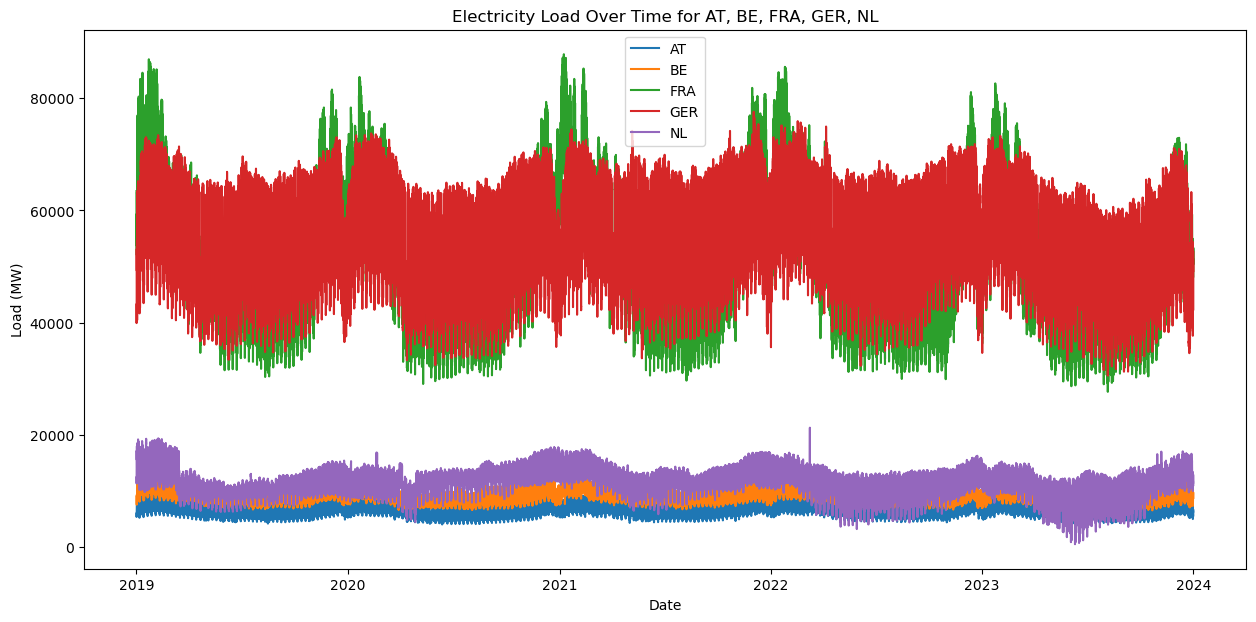

In [11]:
plt.figure(figsize=(15, 7))
for country_code in ['AT', 'BE', 'FRA', 'GER', 'NL']:
    plt.plot(load_df['date'], load_df[f'load_{country_code}'], label=f'{country_code}')

plt.title('Electricity Load Over Time for AT, BE, FRA, GER, NL')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

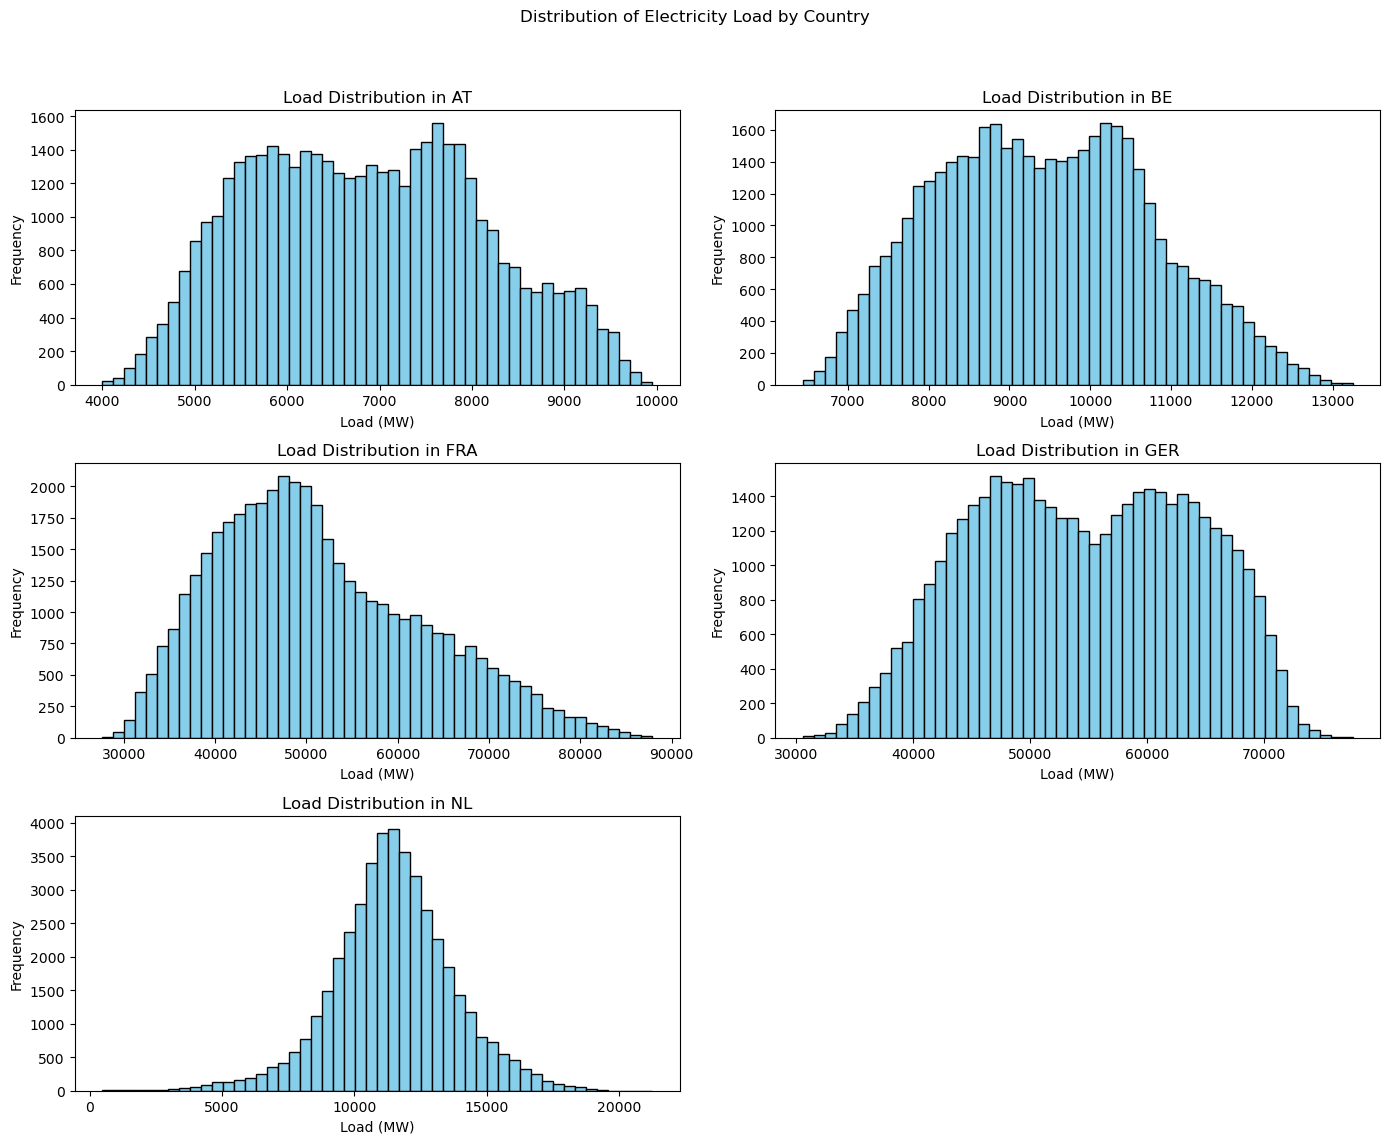

In [14]:
# Histograms for electricity load distribution in each country
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Distribution of Electricity Load by Country')

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms for each country
for i, country_code in enumerate(['AT', 'BE', 'FRA', 'GER', 'NL']):
    axes[i].hist(load_df[f'load_{country_code}'], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Load Distribution in {country_code}')
    axes[i].set_xlabel('Load (MW)')
    axes[i].set_ylabel('Frequency')

# Hide the 6th subplot (no data to display)
axes[-1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [16]:
# Convert all price columns to numeric, coercing errors to NaN for non-numeric values in 'price_FRA'
for col in ['price_AT', 'price_BE', 'price_FRA', 'price_GER', 'price_NL']:
    prices_df[col] = pd.to_numeric(prices_df[col], errors='coerce')

# Check for missing values after conversion
missing_values_prices = prices_df.isnull().sum()

# Fill missing values with the mean of their respective columns
prices_df.fillna(prices_df.mean(), inplace=True)

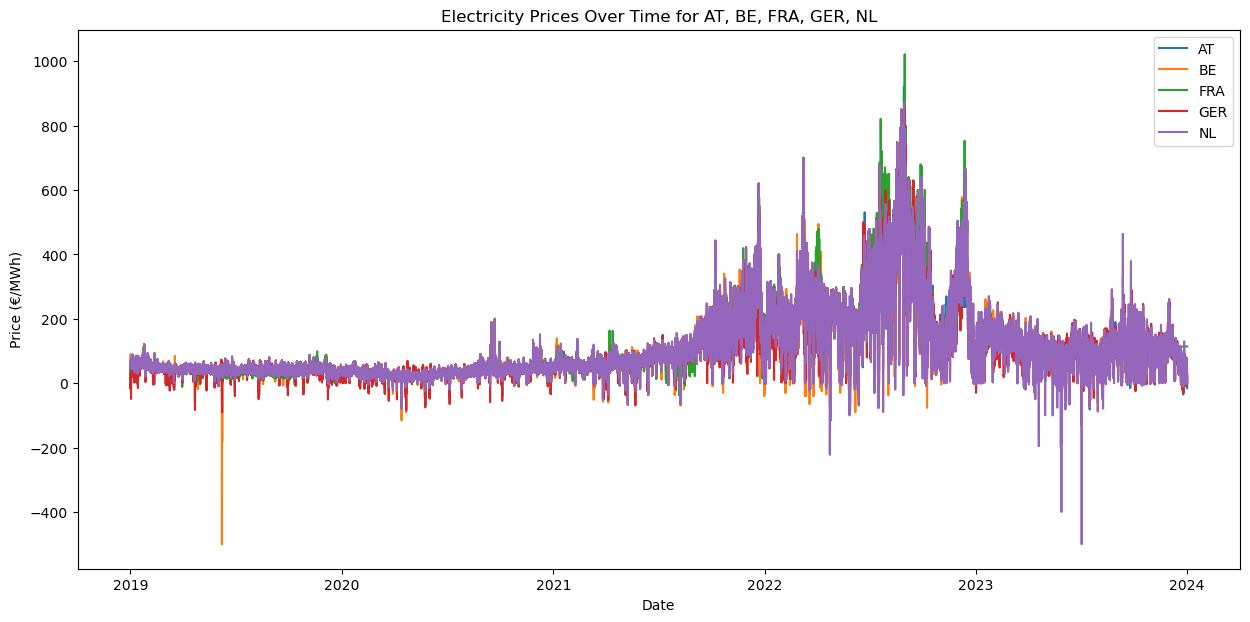

In [17]:
# Time series plot for electricity prices of all countries
plt.figure(figsize=(15, 7))

# Plotting each country's prices over time
for country_code in ['AT', 'BE', 'FRA', 'GER', 'NL']:
    plt.plot(prices_df['date'], prices_df[f'price_{country_code}'], label=f'{country_code}')

plt.title('Electricity Prices Over Time for AT, BE, FRA, GER, NL')
plt.xlabel('Date')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.show()


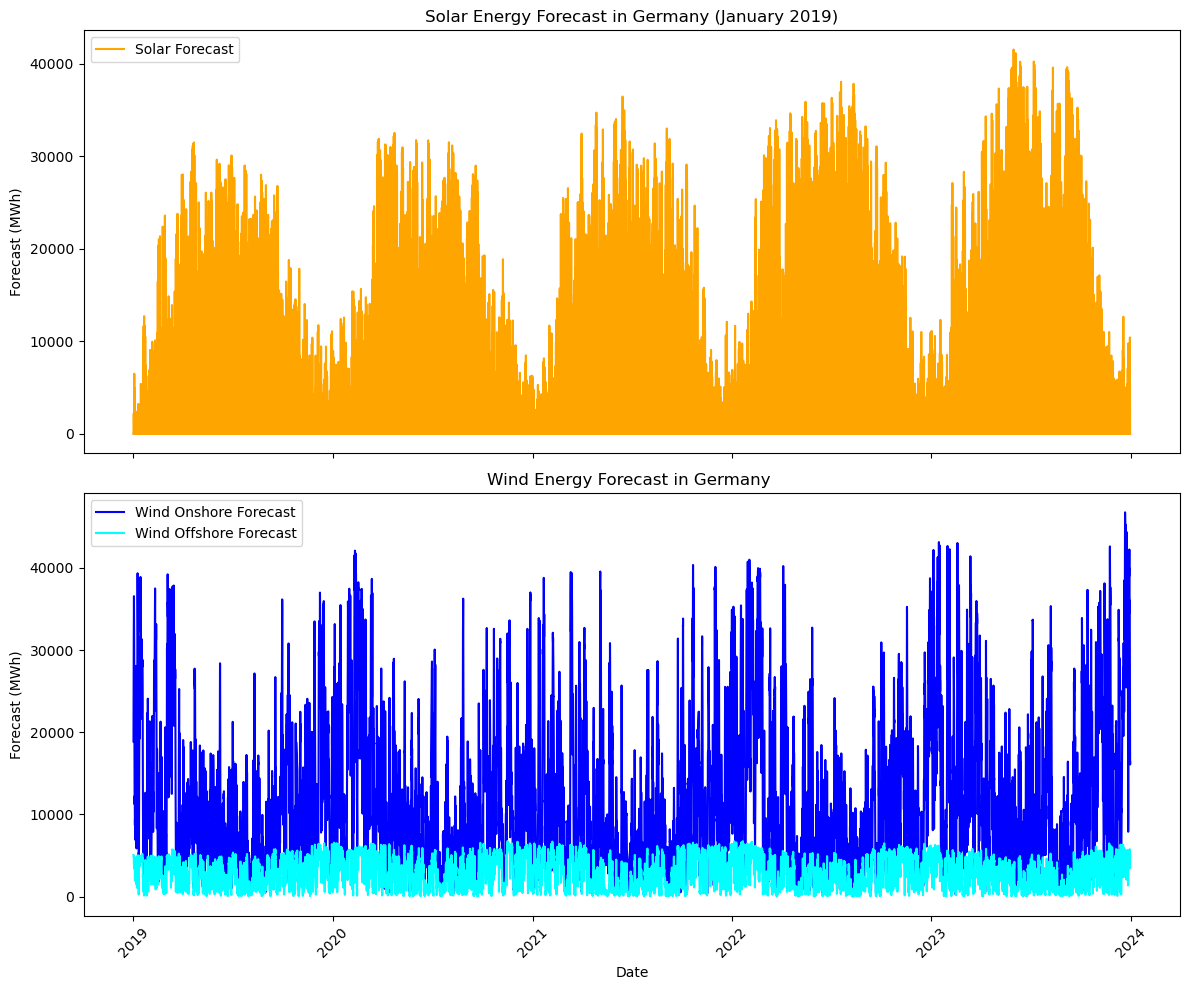

In [6]:
# To manage the large dataset, let's focus on one month of data for visualization
data_subset = res_gen_df[(res_gen_df['date'] >= '2019-01-01') & (res_gen_df['date'] < '2023-12-31')]

# Time series plot for solar and wind energy forecasts in Germany as an example
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Solar forecast for Germany
ax[0].plot(data_subset['date'], data_subset['solar_forecastGER'], label='Solar Forecast', color='orange')
ax[0].set_title('Solar Energy Forecast in Germany (January 2019)')
ax[0].set_ylabel('Forecast (MWh)')
ax[0].legend()

# Wind forecast for Germany (combining onshore and offshore)
ax[1].plot(data_subset['date'], data_subset['windonshore_forecastGER'], label='Wind Onshore Forecast', color='blue')
ax[1].plot(data_subset['date'], data_subset['windoffshore_forecastGER'], label='Wind Offshore Forecast', color='cyan')
ax[1].set_title('Wind Energy Forecast in Germany ')
ax[1].set_ylabel('Forecast (MWh)')
ax[1].set_xlabel('Date')
ax[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


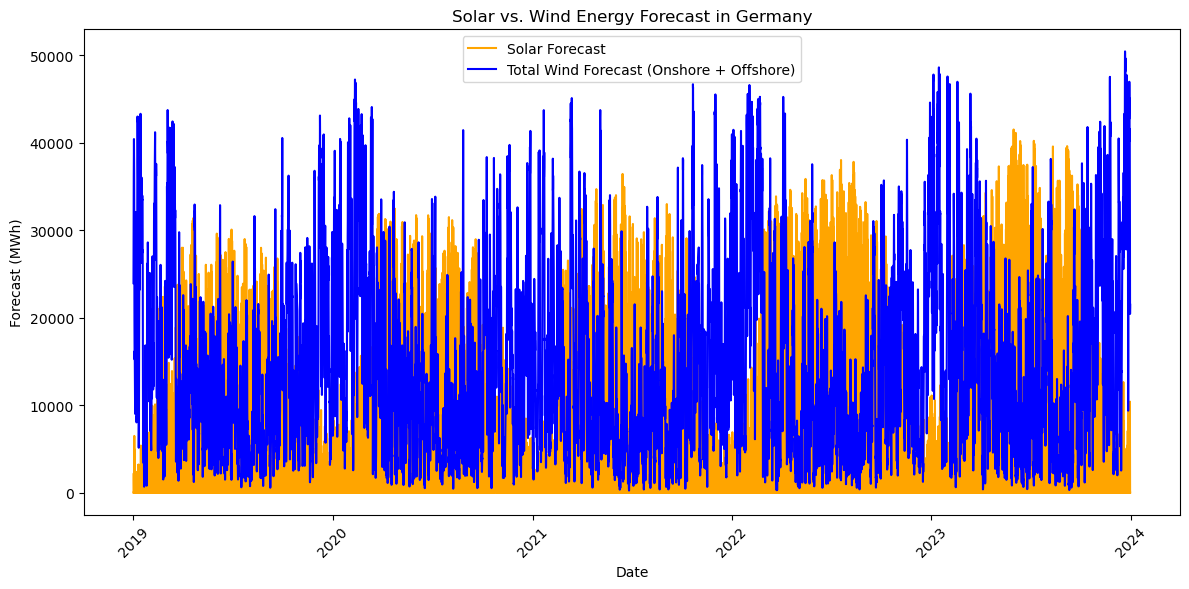

In [7]:
# Comparative plot for solar vs. wind energy forecasts in Germany (January 2019)
fig, ax = plt.subplots(figsize=(12, 6))

# Total wind forecast (onshore + offshore) for Germany
total_wind_forecast_GER = data_subset['windonshore_forecastGER'] + data_subset['windoffshore_forecastGER']

# Plotting
ax.plot(data_subset['date'], data_subset['solar_forecastGER'], label='Solar Forecast', color='orange')
ax.plot(data_subset['date'], total_wind_forecast_GER, label='Total Wind Forecast (Onshore + Offshore)', color='blue')
ax.set_title('Solar vs. Wind Energy Forecast in Germany')
ax.set_ylabel('Forecast (MWh)')
ax.set_xlabel('Date')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


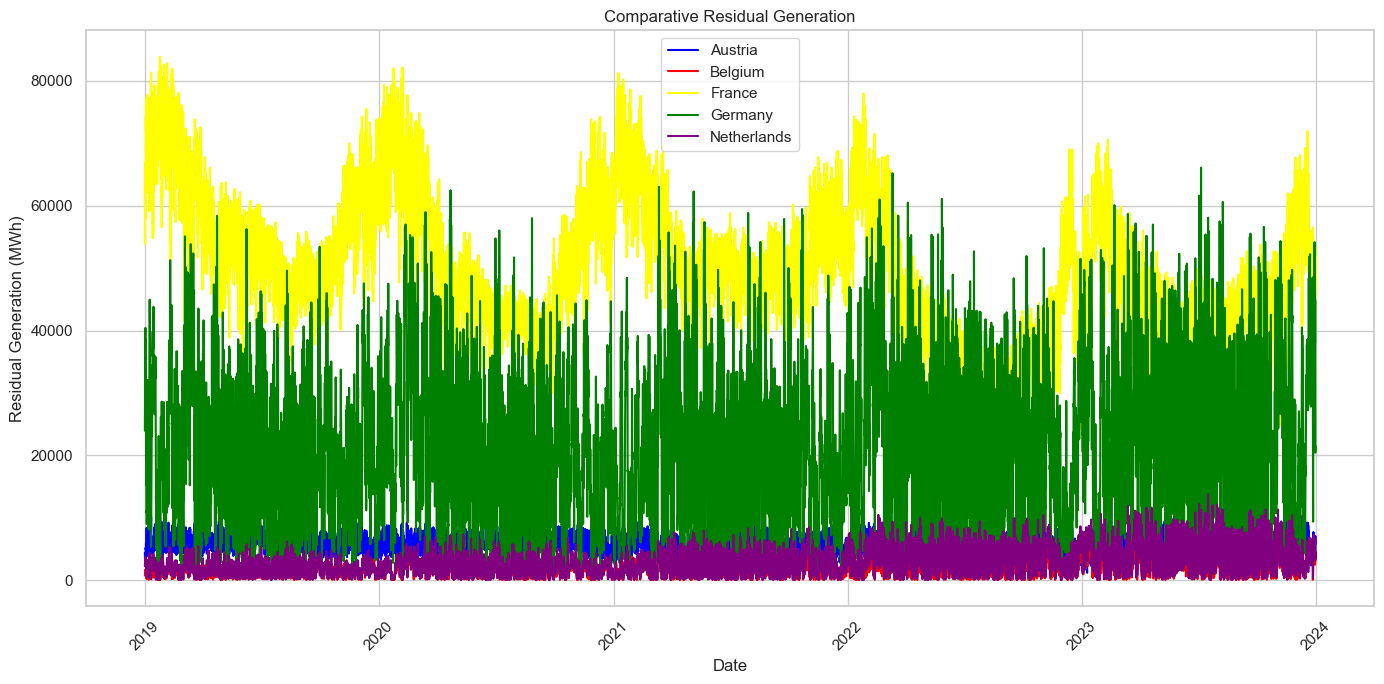

In [15]:
# Comparative plot for residual generation among all countries (January 2019)
plt.figure(figsize=(14, 7))

# Plotting residual generation for each country
plt.plot(new_data_subset['date'], new_data_subset['residual_generationAT'], label='Austria', color='blue')
plt.plot(new_data_subset['date'], new_data_subset['residual_generationBE'], label='Belgium', color='red')
plt.plot(new_data_subset['date'], new_data_subset['residual_generationFRA'], label='France', color='yellow')
plt.plot(new_data_subset['date'], new_data_subset['residual_generationGER'], label='Germany', color='green')
plt.plot(new_data_subset['date'], new_data_subset['residual_generationNL'], label='Netherlands', color='purple')

plt.title('Comparative Residual Generation')
plt.ylabel('Residual Generation (MWh)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


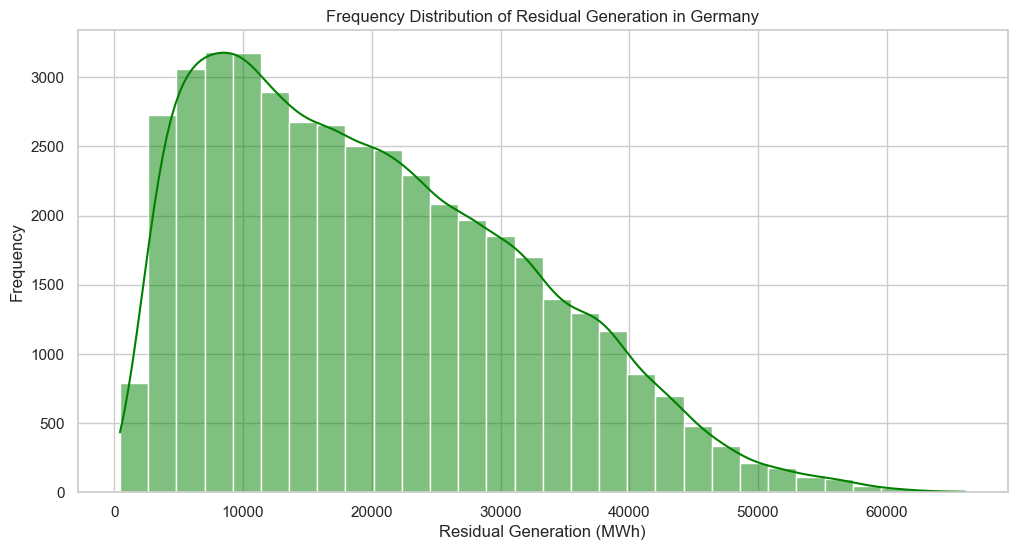

In [17]:
# Set plotting style
sns.set(style="whitegrid")

# Histograms for Frequency Distribution of Residual Generation in Germany
plt.figure(figsize=(12, 6))
sns.histplot(new_data_subset['residual_generationGER'], bins=30, kde=True, color='green')
plt.title('Frequency Distribution of Residual Generation in Germany')
plt.xlabel('Residual Generation (MWh)')
plt.ylabel('Frequency')
plt.show()



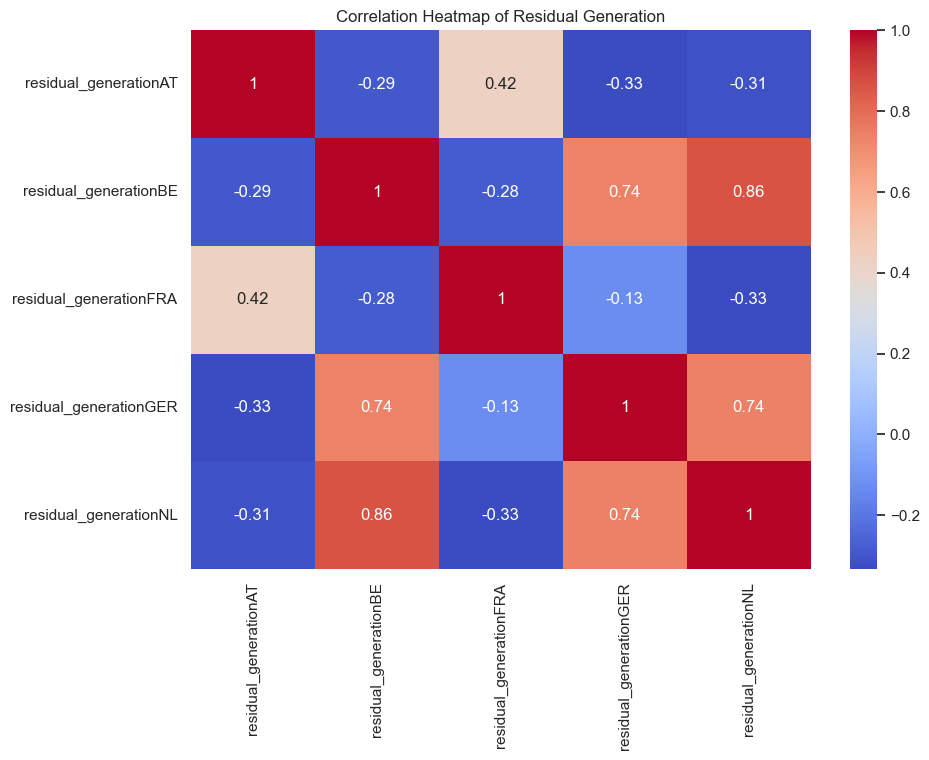

In [19]:
# Correlation Heatmap
plt.figure(figsize=(10, 7))
corr = new_data_subset[['residual_generationAT', 'residual_generationBE', 'residual_generationFRA', 'residual_generationGER', 'residual_generationNL']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Residual Generation')
plt.show()



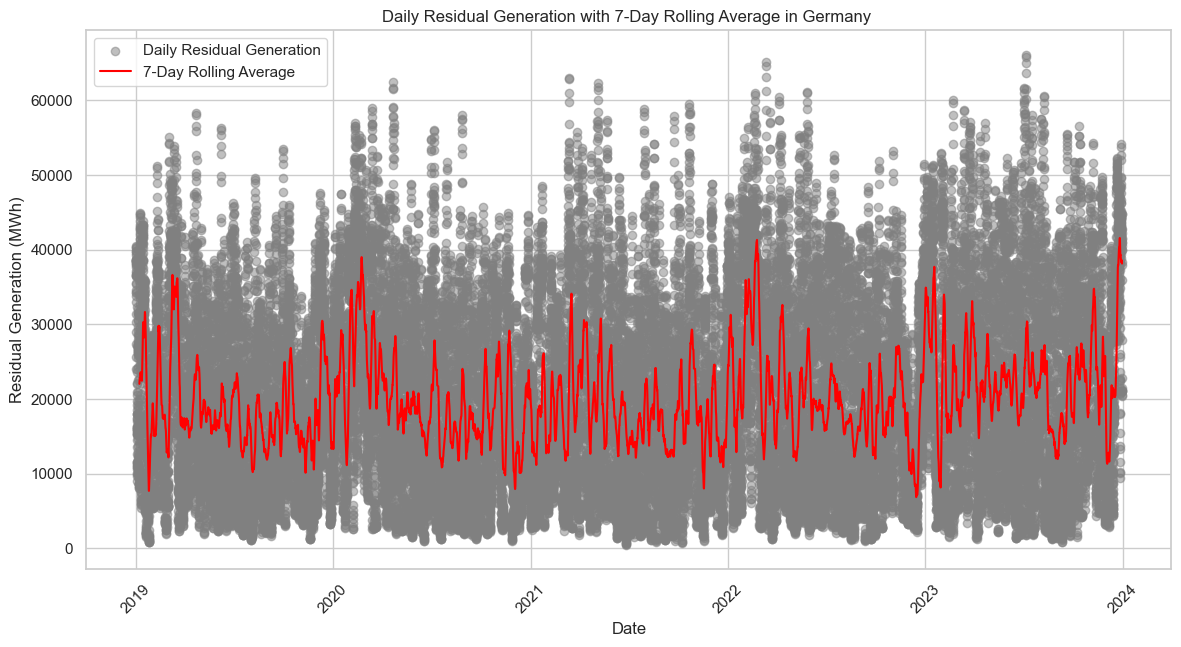

In [22]:
# Scatter Plot with Rolling Average for Germany
rolling_window = 24*7  # 7-day rolling window
plt.figure(figsize=(14, 7))
plt.scatter(new_data_subset['date'], new_data_subset['residual_generationGER'], color='gray', alpha=0.5, label='Daily Residual Generation')
plt.plot(new_data_subset['date'], new_data_subset['residual_generationGER'].rolling(window=rolling_window).mean(), color='red', label='7-Day Rolling Average')
plt.title('Daily Residual Generation with 7-Day Rolling Average in Germany ')
plt.ylabel('Residual Generation (MWh)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.show()

